# Detection of Toxic Comments

Kaggle competition: [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)

In [1]:
seed = 333

## Import

In [2]:
import csv
from datetime import datetime
import string
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout, LSTM, GRU, Activation,GlobalMaxPool1D,Bidirectional
from keras.layers.embeddings import Embedding
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

/Users/mazhurin/keras/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load Embeddings

In [3]:
def read_embeddings(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [4]:
word_to_index, index_to_word, word_to_vec = read_embeddings('./glove/glove.twitter.27B.25d.txt')
word_to_vec["0.065581"] = [ 0.39605,  -0.96669,   0.23706,  -0.41379,  -0.97006,   0.16601,  -1.292,
 -0.58989,   0.11632,  -1.365,    -0.27939,  -0.57222,  -0.97108,  -0.56319,
 -0.015263, -0.70465,  -0.13867 ,  1.0702 ,  -0.25557  , 0.25122,  -0.87755,
  0.70999 ,  0.9118 ,  -0.30077, 0 ]


## Load Data

In [64]:
import nltk, re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk import word_tokenize

# nltk.download('stopwords')
#nltk.download('punkt')
cache_english_stopwords=stopwords.words('english')

replacements = [
    ('f u c k', 'fuck'),
    ('f uck', 'fuck'),
    ('fuckyou', 'fuck you'),
    ('fuckmother', 'fuck mother'),
    ('WTF', 'what the fuck'),
    ('OMFG', 'oh my fucking god'),
    ('RTFM', 'read the fucking manual'),
    ('ASAFP', 'as soon as fucking possible'),
    ('FYVM',  'fuck you very much'),
    ('whatever TF', 'whatever the fuck')
]

def data_clean(message):
    for a,b in replacements:
        message = message.replace(a, b)
    
    temp_tw_list = word_tokenize(message)
    # Remove stopwords
    list_no_stopwords=[i for i in temp_tw_list if i.lower() not in     cache_english_stopwords]
    # Remove hyperlinks
    list_no_hyperlinks=[re.sub(r'https?:\/\/.*\/\w*','',i) for i in list_no_stopwords]
    # Remove hashtags
    list_no_hashtags=[re.sub(r'#', '', i) for i in list_no_hyperlinks]
    #Remove numbers
    list_no_numbers = [re.sub(r'$\d+\W+|\b\d+\b|\W+\d+$','', i) for i in list_no_hashtags]
   # Remove Punctuation and split 's, 't, 've with a space for filter
    list_no_punctuation=[re.sub(r'['+string.punctuation+']+', ' ', i) for i in list_no_numbers]
    # Remove multiple whitespace
    new_sent = ' '.join(list_no_punctuation)
    # Remove any words with 2 or fewer letters
    filtered_list = word_tokenize(new_sent)
    list_filtered = [re.sub(r'^\w\w?$', '', i) for i in filtered_list]
    filtered_sent =' '.join(list_filtered)
    clean_sent=re.sub(r'\s\s+', ' ', filtered_sent)
    #Remove any whitespace at the front of the sentence
    clean_sent=clean_sent.lstrip(' ')
    # remove the articles
    clean_sent = re.sub('(\s+)(a|an|and|the)(\s+)', ' ', clean_sent)

    return clean_sent.lower()


In [65]:
import re
from string import digits
#from nltk.corpus import stopwords
def read_comments(filename = ''):
    comments = []
    labels = []
    ids = []
    remove_punctuation = str.maketrans('', '', string.punctuation)
    remove_digits = str.maketrans('', '', digits)

    with open (filename) as csvDataFile:
        csvReader = csv.reader(csvDataFile)

        header = True
        progress = 0
        for row in csvReader:

            if progress % 10000 == 0:
                print ('Line', progress)
            progress += 1
            
            if header:
                header = False
                continue
            ids.append(row[0])
            #filtered_words = [word for word in s.split() if word not in stopwords.words('english')]
            filtered_words = data_clean(row[1]).split()
            words = []
            for w in filtered_words:
                if w in word_to_vec:
                    words.append(w)
                else:
                    if 'fuck' in w:
                        words.append('fuck')
            comments.append(words)          
            if len(row) > 2:
                classes = []
                for i in range(2,8):
                    classes.append(row[i])
                labels.append(classes)

    ids = np.asarray(ids)
    X = np.asarray(comments)
    Y = np.asarray(labels, dtype=int)

    return ids, X, Y

In [66]:
id_train, X_train, Y_train = read_comments('./data/train.csv')
id_test, X_test, _ = read_comments('./data/test.csv')
labels = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]

max_comment = 0
for i in range(X_train.shape[0]):                               
    l = len(X_train[i])
    if max_comment < l:
        max_comment = l
for i in range(X_test.shape[0]):                               
    l = len(X_test[i])
    if max_comment < l:
        max_comment = l
num_classes = len(labels)
print ('Max word count =', max_comment)

Line 0
Line 10000
Line 20000
Line 30000
Line 40000
Line 50000
Line 60000
Line 70000
Line 80000
Line 90000
Line 100000
Line 110000
Line 120000
Line 130000
Line 140000
Line 150000
Line 0
Line 10000
Line 20000
Line 30000
Line 40000
Line 50000
Line 60000
Line 70000
Line 80000
Line 90000
Line 100000
Line 110000
Line 120000
Line 130000
Line 140000
Line 150000
Max word count = 1666


In [120]:
max_comment = 170

## Split Data

In [8]:
kfold = KFold(n_splits=5,random_state=seed)


In [9]:
folds = list()
for train_index, dev_index in kfold.split(X_train):
    folds.append({
        'train_index' : train_index,
        'dev_index' : dev_index,     
    })

In [29]:
len(X_train[folds[0]['train_index']])

127656

## Custom Loss

In [72]:
from sklearn.metrics import log_loss
from keras.backend import int_shape
import keras.backend as K
import tensorflow as tf
_EPSILON = K.epsilon()
    
def custom_loss(y_true, y_pred):
    losses = []
    y_pred = K.clip(y_pred, _EPSILON, 1.0-_EPSILON)
    num_classes = int_shape(y_pred)[1]
    for i in range(num_classes):
        losses.append(-K.mean(
            y_true[:, i]*K.log(y_pred[:, i]) + (1.0-y_true[:, i])*K.log(1.0-y_pred[:, i]
        ), axis = -1))
    loss = tf.stack(losses)
    loss = K.mean(loss, axis=-1)
        
    return loss

In [11]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        num_classes = int_shape(y_pred)[1]
        true_positives = []
        possible_positives = []
        for i in range(num_classes):
            true_positives.append(K.sum(K.round(K.clip(y_true[:, i] * y_pred[:, i], 0, 1))))
            possible_positives.append(K.sum(K.round(K.clip(y_true[:, i], 0, 1))))
        
        true_positives = K.mean(tf.stack(true_positives), axis=-1) 
        possible_positives = K.mean(tf.stack(possible_positives), axis=-1) 
        
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        num_classes = int_shape(y_pred)[1]
        true_positives = []
        predicted_positives = []
        for i in range(num_classes):
            true_positives.append(K.sum(K.round(K.clip(y_true[:, i] * y_pred[:, i], 0, 1))))
            predicted_positives.append(K.sum(K.round(K.clip(y_pred[:, i], 0, 1))))
        
        true_positives = K.mean(tf.stack(true_positives), axis=-1) 
        predicted_positives = K.mean(tf.stack(predicted_positives), axis=-1) 
        
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Baseline Model

This is naive model based on averaging all word embeddings in a comment.

In [52]:
def average_comment(comment, word_to_vec):
    """
    Converts a comment into a list of words. 
    Extracts the GloVe representation of each word
    and averages its value into a single vector encoding the meaning of the sentence.
    
    Arguments:
    comment -- list of words
    word_to_vec_map -- dictionary mapping every word in a vocabulary 
    into its n-dimensional vector representation
    
    Returns:
    avg -- average vector encoding information about the sentence, numpy-array of shape (n,)
    """
    avg = np.zeros(shape=(len(word_to_vec['apple']), ))
    for w in comment:
        if w in word_to_vec:
            avg += word_to_vec[w]
    avg = avg / len(comment)
    return avg

In [53]:
X_train_avg = list()
for c in X_train:
    X_train_avg.append(average_comment(c, word_to_vec))
X_train_avg = np.asarray(X_train_avg)

edits
made
under
my
username
were
reverted
werent
just
closure
on
some
after
voted
at
please
dont
remove
template
from
talk
page
since
retired
now
matches
this
background
colour
seemingly
stuck
with
talk
man
really
not
trying
to
edit
war
just
that
this
guy
is
constantly
removing
relevant
information
talking
to
me
through
edits
instead
of
my
talk
page
seems
to
care
more
about
formatting
than
actual
info
cant
make
any
real
suggestions
on
improvement
wondered
if
section
statistics
should
be
later
on
or
of
types
of
accidents
think
references
may
need
tidying
so
that
they
are
all
in
exact
same
format
ie
date
format
etc
can
do
that
later
on
if
noone
else
does
first
if
you
have
any
preferences
for
formatting
style
on
references
or
want
to
do
it
yourself
please
let
me
know
appears
to
be
backlog
on
articles
for
review
so
guess
there
may
be
delay
until
reviewer
turns
up
listed
in
relevant
form
eg
sir
are
my
hero
chance
you
remember
what
page
thats
on
from
me
as
well
use
tools
well
·
talk
vandali

/Users/mazhurin/keras/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide



many
unnecessary
details
very
bad
writing
stop
before
you
do
further
damage
to
know
me
yeah
studying
are
always
symmetrical
it
is
stated
that
snowflake
always
has
six
symmetric
arms
assertion
is
simply
not
true
to
rather
unattractive
irregular
crystals
are
by
far
most
common
variety
really
need
to
take
look
at
his
site
get
off
of
it
because
still
see
decent
number
of
on
this
page
forgive
me
new
at
this
dont
want
to
edit
anything
this
in
full
st
paragraph
edit
dont
understand
reasons
for
s
recent
edit
of
this
article
not
that
sure
that
data
are
necessarily
wrong
persuaded
that
strategy
of
introducing
academic
honors
in
first
paragraph
is
unhelpful
approach
to
this
specific
subject
note
that
articles
about
other
sitting
have
been
similarly
enhanced
also
believe
those
changes
are
no
improvement
support
of
my
view
that
this
edit
should
be
reverted
would
invite
anyone
to
revisit
articles
written
about
following
pairs
of
question
becomes
current
version
of
article
about
any
one
of
them
or
e

you
see
him
on
his
recent
appearence
on
with
looks
absolutely
had
to
put
money
on
it
say
that
is
cant
miss
candidate
for
pool
keep
your
malicious
fingers
off
of
my
above
comment
you
remove
it
will
repost
it
this
page
would
also
violate
you
like
it
or
not
conservatives
are
too
like
homosexual
or
heterosexual
is
not
defined
by
sexual
activity
like
year
old
boy
who
is
attracted
to
girl
sexually
but
has
never
had
sex
is
still
straight
person
who
is
actually
sexually
by
same
sex
as
well
as
opposite
sex
is
bisexual
arabs
you
please
stop
enforcing
category
arabs
on
non
arabic
living
in
middle
east
is
wrong
though
not
arabs
have
gone
through
that
needs
to
stop
are
not
arabs
have
our
own
ethnicity
we
shouldnt
be
forced
to
be
called
arabs
is
born
in
middle
east
should
he
be
called
arab
because
of
that
reason
alone
understand
they
are
ie
of
ancestry
most
of
them
speak
though
lot
of
them
are
forgetting
it
someone
who
speaks
you
should
respect
this
fact
not
appease
muslims
who
want
to
call
everyone

condescending
suspect
that
editor
is
racist
you
on
wiki
not
vandalizing
just
having
fun
man
you
have
no
sense
of
humor
if
you
think
vandalizing
stuff
site
now
to
bla
practical
encyclopedia
about
alternative
life
techniques
bla
practical
encyclopedia
about
alternative
life
techniques
some
appropriate
mention
of
article
is
not
without
some
level
of
support
could
not
verify
claim
talk
is
in
state
of
this
article
is
part
of
reason
why
people
are
making
such
confusions
more
ridiculous
is
that
they
you
would
replace
mention
of
in
favor
of
north
slope
of
which
isnt
even
geographical
area
other
than
mountains
in
that
region
are
located
within
continents
yet
for
some
reason
you
refuse
to
allow
this
article
to
be
continent
single
factor
alone
would
have
made
massive
difference
for
readers
tired
of
arguing
with
people
who
are
essentially
refusing
to
nudge
on
given
article
enjoyed
meeting
you
too
was
shocked
by
decision
which
does
not
begin
to
reflect
consensus
just
one
make
it
alone
me
right
for


refactoring
appreciate
any
assistance
welcome
any
questions
when
do
pivotal
accurate
well
referenced
entries
become
peacock
understanding
is
that
it
refers
to
not
to
precise
vital
info
in
sequence
of
events
or
nation
you
are
using
has
been
moved
to
user
space
per
new
link
is
leave
any
questions
you
may
still
have
on
my
talk
page
you
you
actually
take
time
to
do
little
bit
of
research
instead
of
jumping
into
what
you
perceive
to
be
avenue
to
pursue
your
vendetta
against
me
youd
have
realised
by
now
as
would
your
colleague
that
in
all
probability
just
different
terms
in
used
in
different
places
for
same
entity
is
why
challenged
to
produce
something
decent
on
each
which
guarantee
hell
be
unable
to
do
what
seen
with
editors
other
than
elephant
in
room
is
issue
of
hell
you
want
to
call
baiting
one
wants
to
touch
that
one
even
though
its
uncivil
as
hell
appears
to
be
tactic
of
choice
whenever
someone
wants
to
get
rid
of
someone
or
get
their
way
part
that
saddens
me
darkness
are
two
important

not
if
so
it
should
be
noted
that
simply
information
after
it
was
removed
was
not
removal
unwarranted
what
is
problem
why
insist
on
absence
of
this
statement
it
is
unjustifiable
it
is
negligible
am
re
adding
information
as
it
is
sourced
informative
assume
that
since
there
is
no
reason
to
remove
it
again
or
in
first
place
that
you
all
other
will
relax
you
are
concerned
with
useless
edits
please
see
edit
fom
th
know
it
was
carried
out
by
great
but
imho
that
was
first
useless
change
you
are
stupid
fuck
your
mothers
cunt
stinks
talk
new
id
idc
info
user
is
faggot
template
automatically
categorizes
user
in
doesnt
talk
about
those
changes
at
all
was
refering
to
section
that
used
to
be
there
do
not
vandalize
pages
as
you
did
with
this
edit
to
you
continue
to
do
so
you
will
be
blocked
from
editing
echo
is
dead
are
however
leves
of
wounds
hence
emphasis
when
they
are
serious
is
not
adjective
fixed
pic
if
anyone
still
feels
that
it
should
move
it
can
be
done
approval
rating
graph
circle
for
th
a

is
main
point
here
is
did
admin
in
question
no
it
is
until
that
problem
is
addressed
discussing
it
with
that
user
directly
my
account
was
i
likely
to
get
it
eh
buddy
listen
up
will
delete
my
page
account
from
wiki
grommet
you
are
not
going
to
lock
me
keep
my
name
content
or
profile
am
out
of
this
facade
which
is
for
good
delete
it
all
grommet
listas
of
remove
redirect
from
page
that
aircraft
was
distinctly
different
in
design
builder
mission
etc
restore
that
aircrafts
unique
content
to
its
page
more
info
for
entering
this
article
are
few
errors
which
have
corrected
would
have
been
nice
if
you
had
not
simply
cut
pasted
text
from
article
name
was
not
am
looking
at
his
orginal
papers
right
now
also
have
his
orginal
purple
heart
with
olc
man
was
war
hero
in
biggest
ever
myself
am
degree
recieved
of
from
is
interesting
to
note
that
both
aircraft
landed
at
same
airfield
in
for
fixing
that
exquisite
picture
would
like
to
clamp
down
on
them
man
has
also
created
new
words
even
after
modern
lang

instrument
originated
in
now
contemporary
writer
born
in
tells
us
story
about
his
uncle
also
from
area
who
could
memorize
numerous
songs
p
is
also
home
of
born
daughter
of
famous
player
illiterate
she
was
able
to
recite
by
heart
immense
number
of
songs
some
of
which
were
recorded
in
of
folk
poetry
far
from
another
coastal
city
–
was
also
bastion
of
music
this
region
could
be
considered
of
all
players
area
also
gave
birth
to
th
century
priest
who
is
viewed
as
father
of
all
players
of
beyond
honour
work
most
famous
sculptor
built
sculpture
in
showing
in
his
priestly
clothes
playing
instrument
addition
to
produced
great
many
other
followers
of
music
to
dr
fra
who
quotes
work
of
alone
produced
great
number
of
players
starting
with
culminating
with
most
known
–
for
women
they
didnt
play
its
considered
male
activity
only
yet
they
were
actively
involved
in
spreading
music
by
imitating
its
sound
researcher
of
folk
poetry
in
s
states
in
his
book
that
most
of
his
folk
poetry
collection
was
obtai

him
his
family
members
being
killed
here
talk
⋅
will
never
change
our
opinion
talk
is
always
right
also
dont
care
that
he
published
in
almost
all
national
international
outlets
including
scholarly
academic
works
like
here
talk
are
right
are
we
are
right
we
will
never
change
our
opinion
whatever
evidence
you
show
you
ok
notice
that
you
have
been
absent
from
for
few
days
uncharacteristic
so
hope
you
are
not
ill
accept
my
good
wishes
just
wanted
to
see
if
you
are
fine
for
of
reaching
its
still
thanks
for
your
input
a
few
others
images
were
correctly
all
information
was
given
about
images
that
were
necessary
were
even
my
own
gave
full
permission
for
their
use
on
wikipedia
isnt
about
success
phenomenon
that
goes
back
at
least
years
to
days
of
if
you
look
at
section
above
youll
see
it
has
survived
no
fewer
than
four
deletion
discussions
we
do
require
credible
sources
is
removed
on
sight
hate
is
my
topic
is
hate
if
you
hate
person
means
you
like
that
person
hate
can
turn
into
your
love
you
fo

theres
no
need
to
keep
unclear
concepts
wording
when
better
alternative
exists
ask
to
not
revert
using
source
as
reason
when
source
is
actually
book
of
his
authorship
comes
to
mind
routes
to
are
often
mis
read
had
argument
that
flew
to
not
now
would
like
to
challenge
route
that
takes
said
flew
to
from
is
true
but
you
must
connect
through
you
would
stay
on
same
aeroplane
flight
number
between
changes
in
meaning
it
is
not
direct
flight
via
is
how
it
works
you
are
not
sure
please
check
wont
edit
page
now
in
fear
that
will
be
banned
all
other
on
support
you
on
you
are
correct
completely
agree
with
busy
at
moment
but
if
we
need
to
get
permanently
blocked
then
it
should
happen
because
his
vandalism
is
unacceptable
you
for
your
experimenting
with
page
on
test
worked
it
has
been
reverted
or
removed
use
sandbox
for
any
other
tests
you
may
want
to
do
look
at
welcome
page
to
learn
more
about
contributing
to
our
encyclopedia
go
i
omg
you
are
admin
you
protect
people
who
vandalise
article
these
att

is
name
of
film
in
but
this
turned
out
to
be
false
it
seems
to
me
looks
more
like
his
mother
than
his
father
do
you
think
how
authentic
is
portrayal
of
in
this
film
you
have
any
historical
insights
source
for
for
uploading
noticed
that
files
description
page
currently
doesnt
specify
who
created
content
so
copyright
status
is
unclear
you
did
not
create
this
file
yourself
then
you
will
need
to
specify
owner
of
copyright
you
obtained
it
from
website
then
link
to
website
from
which
it
was
taken
together
with
of
that
websites
terms
of
use
of
its
content
is
usually
sufficient
information
if
copyright
holder
is
different
from
websites
publisher
then
their
copyright
should
also
be
acknowledged
well
as
adding
source
please
add
proper
copyright
licensing
tag
if
file
doesnt
have
one
already
you
picture
audio
or
video
then
tag
can
be
used
to
release
it
under
you
believe
media
meets
criteria
at
use
use
tag
such
as
or
one
of
other
tags
listed
at
copyright
use
copyright
tags
for
full
list
of
copyrigh

was
wondering
about
your
motivation
check
this
personal
page
very
often
leave
messages
here
on
on
discussion
page
thanks
to
you
for
this
note
that
am
being
dressed
down
for
everything
from
being
nice
to
editors
like
to
work
with
all
way
to
deleting
messy
posts
from
my
own
talk
page
mess
is
mess
thanks
dont
take
that
as
gratuitous
or
dont
care
what
you
say
here
dont
believe
one
sentence
anymore
you
want
nightcap
tell
me
mins
mins
mins
mins
de
mins
mins
for
mins
for
of
mins
for
mins
mins
am
not
anything
was
my
home
was
born
raised
blocks
from
it
was
once
greatest
place
in
this
country
am
not
interested
in
globalization
look
at
square
see
smoking
ruin
of
my
home
this
happens
to
you
hope
globalization
is
comfort
enough
for
you
is
approved
by
my
observations
see
eg
history
of
partisan
youre
first
to
object
btw
speaking
of
genocide
if
we
are
to
follow
wikipedia
conventions
of
most
common
name
dont
agree
is
most
common
name
as
we
also
have
proven
many
times
before
we
should
change
name
of
cur

KeyboardInterrupt: 

In [35]:
X_test_avg = list()
for c in X_test:
    X_test_avg.append(average_comment(c, word_to_vec))
X_test_avg = np.asarray(X_test_avg)

/Users/mazhurin/keras/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


In [55]:
def baseline_model(num_dim=25, num_labels=6):
    # create model
    model = Sequential()
    model.add(Dense(num_labels, input_shape=(num_dim,), kernel_initializer='normal', activation='relu'))
    model.add(Dense(units=num_labels, activation='sigmoid'))
    model.compile(
        #loss='binary_crossentropy', 
        loss=custom_loss,
        optimizer='adam', 
        #metrics=['accuracy'])
        metrics=['accuracy', f1])

    return model

In [56]:
model = baseline_model()

In [57]:
model.fit(X_train_avg, Y_train, epochs=100, verbose=1)

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 array(s), but instead got the following list of 513 arrays: [array([[-0.04391836],
       [ 0.38700692],
       [ 0.30566192],
       [-0.28469936],
       [-0.12002728],
       [-0.47434092],
       [ 0.92552244],
       [-0.5273368 ],
       [-0.17688892],
 ...

In [42]:
model.predict(X_train_avg[3003:3005])

array([[nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan]], dtype=float32)

## Cross Validation

In [71]:
np.random.seed(seed)
estimator_baseline = KerasRegressor(build_fn=baseline_model, 
                                    nb_epoch=1, batch_size=5, verbose=1)
results = cross_val_score(estimator_baseline, averages, Y_train, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

## RNN

In [85]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    m = X.shape[0]                                   # number of training examples
    X_indices = np.zeros(shape=(m, max_len))
    for i in range(m):                               
        sentence_words = X[i]
        if len(sentence_words) > max_len:
            #print ("Too many words:", len(sentence_words))
            continue
        j = 0
        for w in sentence_words:
            if w in word_to_index:
                X_indices[i, j] = word_to_index[w]
            else :
                X_indices[i, j] = word_to_index['word']
            j = j + 1
    return X_indices

In [121]:
X_train_indices = sentences_to_indices(X_train, word_to_index, max_comment)
X_test_indices = sentences_to_indices(X_test, word_to_index, max_comment)

In [122]:
def pretrained_embedding_layer(word_to_vec, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 
    
    Arguments:
    word_to_vec -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    # adding 1 to fit Keras embedding (requirement)
    vocab_len = len(word_to_index) + 1                  
    emb_dim = word_to_vec["cucumber"].shape[0]  
    emb_matrix = np.zeros(shape=(vocab_len, emb_dim))
    
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec[word]

    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    return embedding_layer

In [127]:
def rnn_model(input_shape, num_classes, word_to_vec, word_to_index):
    """
    Create the model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec -- dictionary mapping every word in a vocabulary into its n-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary 

    Returns:
    model -- a model instance in Keras
    """
    sentence_indices = Input(shape=input_shape, dtype='float32')
    embedding_layer = pretrained_embedding_layer(word_to_vec, word_to_index)
    embeddings = embedding_layer(sentence_indices)   
    
    X = GRU(96, return_sequences = True)(embeddings)
    #X = Bidirectional(LSTM(64, return_sequences = False))(embeddings) 
    X = Dropout(rate=0.05)(X)
    X = LSTM(32, return_sequences = False)(X)
    X = Dropout(rate=0.05)(X)
#     X = Dense(units=30, activation='relu')(X)
#     X = Dropout(0.1)(X)
    X = Dense(units=num_classes, activation='sigmoid')(X)
    model = Model(inputs = [sentence_indices], outputs = X)
    
    return model

In [128]:
model_RNN = rnn_model((max_comment,), num_classes, word_to_vec, word_to_index)
model_RNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 170)               0         
_________________________________________________________________
embedding_16 (Embedding)     (None, 170, 25)           29837875  
_________________________________________________________________
gru_15 (GRU)                 (None, 170, 96)           35136     
_________________________________________________________________
dropout_31 (Dropout)         (None, 170, 96)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                16512     
_________________________________________________________________
dropout_32 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 6)                 198       
Total para

In [129]:
model_RNN.compile(
    #loss='binary_crossentropy', 
    loss=custom_loss,
    optimizer='adam', 
    #metrics=['accuracy']
    metrics=['accuracy', f1]
)

In [ ]:
model_RNN.fit(X_train_indices, Y_train, epochs = 50, batch_size = 64, shuffle=True, verbose=True)


Epoch 1/50
159571/159571 [==============================] - 946s 6ms/step - loss: 0.1313 - acc: 0.9403 - f1: 0.1131
Epoch 2/50
159571/159571 [==============================] - 923s 6ms/step - loss: 0.0606 - acc: 0.9917 - f1: 0.6297
Epoch 3/50
159571/159571 [==============================] - 890s 6ms/step - loss: 0.0568 - acc: 0.9925 - f1: 0.6561
Epoch 4/50
159571/159571 [==============================] - 908s 6ms/step - loss: 0.0543 - acc: 0.9930 - f1: 0.6730
Epoch 5/50
159571/159571 [==============================] - 874s 5ms/step - loss: 0.0527 - acc: 0.9917 - f1: 0.6800
Epoch 6/50
159571/159571 [==============================] - 874s 5ms/step - loss: 0.0509 - acc: 0.9935 - f1: 0.6874
Epoch 7/50
159571/159571 [==============================] - 905s 6ms/step - loss: 0.0495 - acc: 0.9939 - f1: 0.6934
Epoch 8/50
159571/159571 [==============================] - 879s 6ms/step - loss: 0.0483 - acc: 0.9939 - f1: 0.7022
Epoch 9/50
159571/159571 [==============================] - 897s 6ms/ste

## Testing

In [20]:
import matplotlib.pyplot as plt

def plot_predictions(probabilities, title):
    fig = plt.figure(figsize=(12, 4))
    fig.suptitle(title)
    plt.autoscale(enable=False, axis='y')
    width = 0.85
    ind = np.arange(len(probabilities))
    plt.bar(ind, probabilities, width=width, color='g')
    plt.xticks(ind, labels)
    
def predict(text, model):
    plot_predictions(model.predict(sentences_to_indices(
        np.asarray([text.split()]),word_to_index, max_comment))[0], text)    

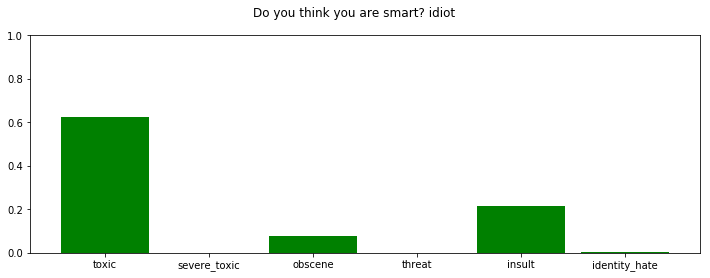

In [101]:
predict("Do you think you are smart? idiot", model_RNN)

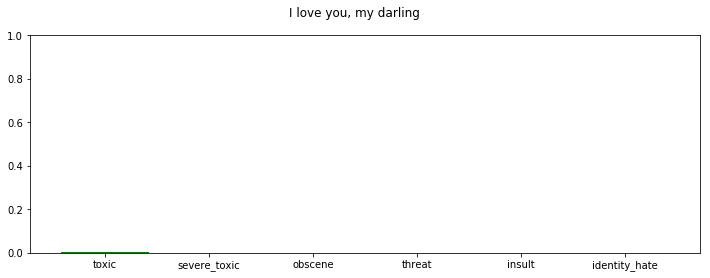

In [102]:
predict("I love you, my darling", model_RNN)

## Submission

In [103]:
y = model_RNN.predict(X_test_indices)
#y = model.predict(X_test_avg)

In [104]:
result = pd.concat([
    pd.DataFrame(id_test, columns=['id']), 
    pd.DataFrame(y, columns=labels)], axis=1)
result = result.set_index('id')
result = result.fillna(0.0)



result.to_csv('./result/anton_rnn_clean_50epocs{}.csv'.format(datetime.now()), header=True)


